<font color=blue>
<b>Полезные ссылки:</b> по анализу текстов:
    
Основы Natural Language Processing для текста  — https://habr.com/ru/company/Voximplant/blog/446738/
    
Интересная статья в общем по NLP — https://habr.com/ru/company/oleg-bunin/blog/352614/
    
BERT, ELMO и Ко в картинках (как в NLP пришло трансферное обучение) — https://habr.com/ru/post/487358/
    
В частности, BERT является довольно популярной моделью. Вот еще информация по этой модели:
    
https://habr.com/ru/post/436878/
    
http://jalammar.github.io/illustrated-bert/; https://huggingface.co/docs/transformers/model_doc/bert
    
И другие ссылки: 
    
http://jalammar.github.io/illustrated-word2vec/
    
https://colah.github.io/posts/2015-08-Understanding-LSTMs/
    
http://jalammar.github.io/illustrated-transformer/
    
https://colab.research.google.com/drive/1SBha91u6142pW5mSiQOOjJWCCSAFj4HI?usp=sharing    
 
</font>

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dara Loading and Preprocessing</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclustions</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# 01 - ***ML for Texts*** - Project for WikiShop

[Nice reading about BERT](https://docs.deeppavlov.ai/en/master/features/models/bert.html)

BERT (Bidirectional Encoder Representations from Transformers) is a Transformer pre-trained on masked language model and next sentence prediction tasks. This approach showed state-of-the-art results on a wide range of NLP tasks in English.

### Project Goal
The project goal is a binary text classification using BERT model.

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [72]:
# 1 - импорты из стандартной библиотеки
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import re
# import torch
# import transformers
import warnings

# 2 - импорты сторонних библиотек
from catboost import CatBoostClassifier
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from tqdm import notebook
from tqdm import tqdm

# 3 - импорты модулей текущего проекта
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None 
tqdm.pandas()

## Подготовка

In [ ]:
# read the file handling exceptions
try:
    data = pd.read_csv("C:\\Users\\HOME\\PycharmProjects\\ZAF202301_NLP_ToxicCommentsClassification\\toxic_comments.csv", index_col=[0])
except FileNotFoundError:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.toxic.unique()

array([0, 1])

In [5]:
# проверка на пропуски в таргете
data['toxic'].isna().sum()

0

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера:</b> Данные загружены успешно!
    
Желательно посмотреть на баланс классов в датасете.

</div>

### Проверка на дисбаланс таргета

In [6]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

### ***Вывод:*** Видим, что таргет не сбалансирован. Это нужно учесть при подготовке обучающей выборки. Так как для наилучшего обучения модели целевое значение должно быть сбалансировано.

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Правильно, что обращаешь внимание на дисбаланс классов!

</div>

### Работаем со стоп-словами

In [7]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuliabezginova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Переведём тексты в стандартный для Python формат: кодировку Unicode U.

<div class="alert alert-danger">
<b>🚫 Комментарий ревьювера:</b> Нужно убрать преобразование в юникод, т.к. текст на английском языке — это не требуется и занимает дополнительное время.

</div>

In [8]:
# Изменим кодировку методом astype():
# corpus = data['text'].values.astype('U')
# corpus_train = X_train.values.astype('U')
# corpus_test = X_test.values.astype('U')

<div class="alert alert-info"> <b>ℹ️ Yulia:</b> 
    
Убрала.

</div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Хорошо

</div>

### Создадим функцию для лемматизации и очистки текста

In [9]:
corpus = list(data['text'])

In [10]:
def lemmatize(text):
    lemmatizer = nltk.WordNetLemmatizer()
    
    lem_text = " ".join(lemmatizer.lemmatize(word) for word in text.split())
    
    lem_final = re.sub(r'[^a-zA-Z ]', '', lem_text)
    
    return lem_final.lower()

<div class="alert alert-danger">
<b>🚫 Комментарий ревьювера:</b> К сожалению лемматизатор Mystem подходит только для русского языка. Вместо него можно применить, например WordNetLemmatizer(). 
    
Пример кода можно взять из тренажера. Обрати внимание, что лемматизацию мы должны применять к каждому токену (слову в тексте). Например таким образом:
    
    lemm_text = " ".join(lemmatizer.lemmatize(word) for word in text.split())


</div>

<div class="alert alert-info"> <b>ℹ️ Yulia:</b> 
    
Поправила.

</div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Все правильно, только очистку текста лучше поставить перед лемматизацией.

</div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> На будущее, если будет интересно более углубленное изучение анализа текстов, можешь попробовать другие способы лемматизации. 
    
1. Лемматизация с помощью Spacy. Но если делать на всем датасете, может занять 0,5-1 час, в зависимости от возможностей компьютера.
https://spacy.io/ или https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/

2. Использовать POS-теги, это сделает лемматизацию точнее:
https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
    
Это занимает больше времени, поэтому можешь проверить локально, на небольшой выборке. 
    
Для контроля времени лемматизации, поскольку процесс длительный, можно применять индикатор прогресса. Различные варианты можно посмотреть здесь: 
    
https://habr.com/ru/post/483400/ 
    
Пример:
    
    from tqdm import tqdm
    tqdm.pandas()
    data['lemm_text'] = data['text'].progress_apply(lemmatize)

</div>

#### Протестируем работу функции лемматизации и очистки текста.

In [11]:
print("Исходный текст:", corpus[100])
print("Очищенный и лемматизированный текст:", lemmatize(corpus[100]))

Исходный текст: However, the Moonlite edit noted by golden daph was me (on optus ...)  Wake up wikkis.  So funny
Очищенный и лемматизированный текст: however the moonlite edit noted by golden daph wa me on optus  wake up wikkis so funny


<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> В данном примере и в тексте ниже видно, что очистка текста отработала, но преобразования к исходной форме не видно. 
    
Стоит отметить, что даже WordNetLemmatizer() преобразовывает далеко не все слова, но в целом по нескольким строчкам можно будет увидеть изменение.
    
</div>

#### Применим функцию для лемматизации и очистки текста

In [12]:
# applying the function without tracking the progress
# data['lem_text'] = data.text.apply(lemmatize)

# lemmatizing with tracking the progress
data['lem_text'] = data['text'].progress_apply(lemmatize)

100%|█████████████████████████████████| 159292/159292 [01:01<00:00, 2602.91it/s]


In [13]:
data.head()

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,daww he match this background colour im seemin...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cant make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Лемматизация выполнена успешно

</div>

### Разделим данные на тестовую и обучающую выборки

In [14]:
features = data.drop(columns='toxic', axis=1)
target = data['toxic']

In [15]:
features.shape

(159292, 2)

In [16]:
target.shape

(159292,)

In [17]:
# Разделяю на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, 
                                                    random_state=5)

In [18]:
print('Train features sample size:', X_train.shape[0])
print('Train target sample size:', y_train.shape[0])
print()
print('Test features sample size:', X_test.shape[0])
print('Test target sample size:', y_test.shape[0])
print()
print('Test sample, %:', round(X_test.shape[0] / (X_test.shape[0] + X_train.shape[0]) * 100, 2))

Train features sample size: 127433
Train target sample size: 127433

Test features sample size: 31859
Test target sample size: 31859

Test sample, %: 20.0


### Проведем upsampling для корректировки дисбаланса таргетов в обучающей выборке

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Как рекомендация, лучше учитывать дисбаланс классов в моделях, например:
    
    class_weight = 'balanced'

</div>

In [19]:
# функция upsample для создания сбалансированности выборки 
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    
    target_zeros = target[target == 0]  
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=5)
    
    return features_upsampled, target_upsampled

In [20]:
# upsample for target disbalance correction
X_train_up, y_train_up = upsample(X_train,
                                  y_train,
                                  repeat = 5)

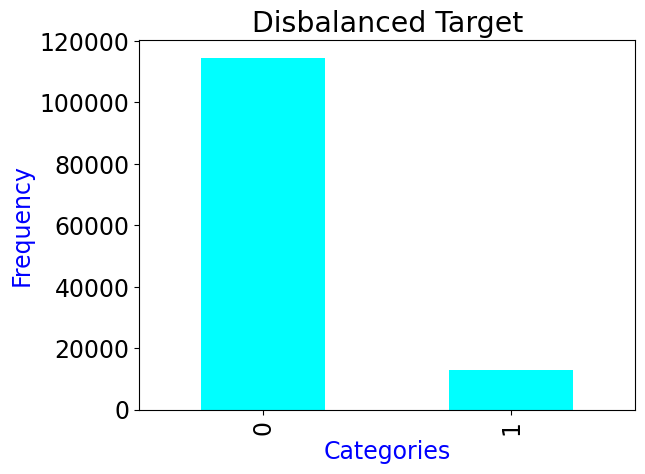

In [63]:
y_train.value_counts().plot(kind='bar', color=['cyan'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

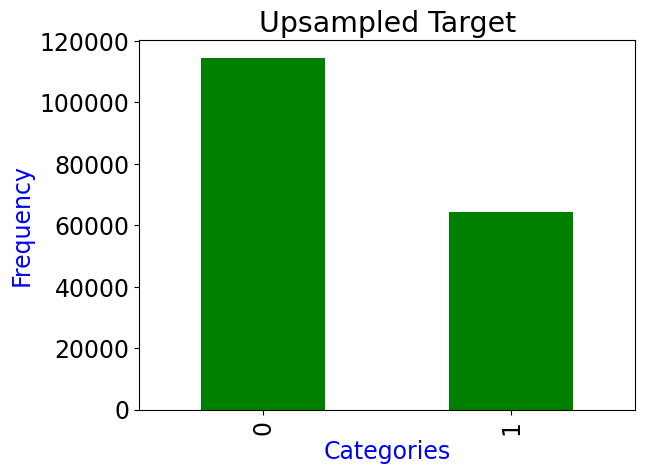

In [64]:
y_train_up.value_counts().plot(kind='bar', color='green')

plt.title('Upsampled Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v3:</b> Отлично!

</div>

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера v2:</b> К сожалению, данная гистограмма не отображает реальную картину. Как вариант, можно построить две гистограммы, и мы увидим, как изменился баланс классов. Желательно также добавить подписи к диаграммам.
    
Стоит отметить, что мы не обеспечили полный баланс классов, осталась некоторая несбалансированность. Это поможет для обучения модели, но не сильно. 
    
Поэтому лучше не останавливаться на полумерах =)
    
В целом, рекомендую применить балансировку внутри моделей.
    
Вообще upsampling просто дублирует строчки в малом классе, новых данных он не приносит.
    
При анализе текстов применяют также аугментацию, например слова заменяют синонимами. Но это непростая задача, можно почитать здесь:
    
https://alexanderdyakonov.wordpress.com/2020/11/09/text-augmentation/#:~:text=%D0%90%D1%83%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F%20(augmentation)%20%E2%80%93%20%D1%8D%D1%82%D0%BE%20%D0%BF%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5,%D0%BC%D0%B5%D0%BD%D1%8F%D1%8E%D1%82%20(%D0%B8%D0%BD%D0%BE%D0%B3%D0%B4%D0%B0%20%D1%81%D1%83%D1%89%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE)%20%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D1%8F.

</div>

### Таргетные значения теперь сбалансированы лучше, что положительно скажется на обучении.

### ВЫВОД: Исходные данные разделены на тестовые и обучающие, выделены признаки и таргетные значения. Дальнейшие преобразования текста будем производить только с признаками (текстом).

Применим модель "мешка слов" к набору данных.

### Реализуем модель «мешка слов» в классе CountVectorizer

Мы импортируем класс CountVectorizer, создам экземпляр класса и подгоняем модель к нашим данным для анализа тональности твитов.

In [22]:
vect = CountVectorizer(stop_words=stopwords)

In [23]:
# Считаю Tf-idf для обучающей
X_train_vect = vect.fit_transform(X_train.lem_text)

# Считаю Tf-idf для тестовой
X_test_vect = vect.transform(X_test.lem_text)

Перед тем как мы пытаемся улучшить выделение признаков, давайте измерим качество модели, построив классификатор. 

У нас есть обучающие метки, хранящиеся в y_train и обучающие данные, представленные в виде «мешка слов» X_train, таким образом, мы можем обучить классификатор по этим данным. 

Как правило, для подобных высокоразмерных разреженных данных лучше всего работают линейные модели типа LogisticRegression.

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Все правильно, согласен с твоими выводами! Даже с параметрами модели по умолчанию мы сможем увидеть отличия.
</div>

### Масштабирование признаков с помощью TF-IDF

Следующий подход вместо исключения несущественных признаков пытается масштабировать признаки в зависимости от степени их информативности. Одним из наиболее распространенных способов такого масштабирования является метод частота термина-обратная частота документа (term frequency-inverse document frequency, tf-idf). 

**Идея этого метода заключается в том, чтобы присвоить большой вес термину, который часто встречается в конкретном документе, но при этом редко встречается в остальных документах корпуса. Если слово часто появляется в конкретном документе, но при этом редко встречается в остальных документах, оно, вероятно, будет описывать содержимое этого документа лучше.**

Мешок слов учитывает частоту употребления слов. Посмотрим, как часто уникальное слово встречается во всём корпусе и в отдельном его тексте.

Оценка важности слова определяется величиной TF-IDF (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»). То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

#### TFIDF = TF * IDF

IDF нужна в формуле, чтобы уменьшить вес слов, наиболее
распространённых в любом другом тексте заданного корпуса.
IDF зависит от общего числа текстов в корпусе (D) и количества
текстов, в которых это слово встречается (d).

Большая величина TF-IDF говорит об уникальности слова в тексте
по отношению к корпусу. Чем чаще оно встречается в конкретном
тексте и реже в остальных, тем выше значение TF-IDF.

**Если данные разделены на обучающую и тестовую выборки,
функцию fit() запустим только на обучающей. Иначе тестирование
будет нечестным: в модели будут учтены частоты слов из тестовой
выборки.**

Сначала переведем выборки X_train, X_test в векторный вид.


In [24]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

#### ***Несбалансированная выборка таргетов***

In [25]:
# Считаю Tf-idf для обучающей
tf_idf_X_train = count_tf_idf.fit_transform(X_train['lem_text'])

# Считаю Tf-idf для тестовой
tf_idf_X_test = count_tf_idf.transform(X_test['lem_text'])

In [26]:
print("Размер матрицы TF-IDF X_train:", tf_idf_X_train.shape)
print("Размер матрицы TF-IDF X_test:", tf_idf_X_test.shape)

Размер матрицы TF-IDF X_train: (127433, 191019)
Размер матрицы TF-IDF X_test: (31859, 191019)


#### ***Cбалансированная выборка таргетов***

In [27]:
# Считаю Tf-idf для обучающей
tf_idf_X_train_up = count_tf_idf.fit_transform(X_train_up['lem_text'])

In [28]:
print("Размер матрицы TF-IDF X_train_up:", tf_idf_X_train_up.shape)

Размер матрицы TF-IDF X_train_up: (179009, 191019)


### ВЫВОД: Данные очищены от странных букв и знаков, знаки пунктуации и стоп-слова удалены, данные разделены на тестовую и обучающую выборки, в каждой из которой выделены признаки и целевое значение. Выборки признаков приведены к векторному виду и готовы к обучению.

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Разделение на выборки и векторизация текста выполнены успешно!
    
</div>

## Обучение

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> На будущее хочу посоветовать, как можно улучшить обучение моделей, в том числе и для задач предсказания тональности текста.
    
Обычно мы обучаем на выборке train и применяем кросс-валидацию, например GridSearchCV. Но когда используется кросс-валидация, получается, что модель в итоге обучается на всей обучающей выборке и это немного не правильно — происходит утечка данных. 
    
В таких случаях рекомендуется оборачивать конструкцию в Pipeline. Вот здесь можно посмотреть примеры применения:
    
https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05
    
https://habr.com/ru/post/538458/
    
Pipeline + GridSearchCV: https://towardsdatascience.com/nlp-with-pipeline-gridsearch-5922266e82f4
    
Таким образом в GridSearchCV можно добавить пайплайн — но это не обязательно для выполнения данной работы.
    
В данном случае в pipeline можно завести функцию upsampling, tf-idf и модель для машинного обучения.
</div>

<div class="alert alert-danger">
<b>🚫 Комментарий ревьювера:</b> Общее замечание по обучению моделей:
    
Мы должны только одну модель проверить на тестовой выборке.
    
Почему это важно? Дело в том, что в реальности нам недоступна тестовая выборка, поэтому мы сами должны организовать проверку качества модели. Для этого берем выборки train, делаем кросс-валидацию. 
    
На основе кросс-валидации мы должны выбрать лучшую модель и векторизатор, а затем ее проверить на тестовой выборке.
    
</div>

<div class="alert alert-info"> <b>ℹ️ Yulia:</b> 
    
я вроде так и делаю... по best_score_ выбираю лучшее значение и затем уже лучшую модель в разделе выводы тестирую. или ты про что-то другое?

</div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Да, выбираем лучшую модель и только ее одну тестируем. Просто сейчас у тебя тестирование на нскольких моделях.
    
</div>

### Logistic Regression с использованием перекрестной проверки для модели «мешка слов» в классе CountVectorizer()

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v3:</b> Pipeline пока решила не пробовать ?)

</div>

In [ ]:
pipe_lr = Pipeline([(‘vect’, CountVectorizer()),
 (‘tfidf’, TfidfTransformer()),
 (‘model’, LogisticRegression())])

model = pipe_lr.fit(x_train, y_train)

prediction = model.predict(x_test)

print(“\naccuracy: {}%”.format(round(accuracy_score(y_test, prediction)*100,2)))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))

In [29]:
logreg = LogisticRegression(class_weight = 'balanced', 
                            random_state=5)

In [30]:
param_grid = [
    {'C': [0.01, 0.1, 1, 2, 10, 100], 
     'penalty': ['l1', 'l2']}
]

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера:</b> По умолчанию в функции GridSearchCV рассчитывается метрика accuracy. В данном задании нас интересует F-мера. Нужно добавить целевую метрику:
    
    scoring='f1'

Поскольку классы несбалансированы, метрика accuracy не позволяет правильно оценить качество обучения. Подробнее о дисбалансе классов и влиянии на задачи можно почитать здесь:
    
https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/
    
***
    
P.S. дальше увидел, что ты рассчитываешь F-меру. Но подбор гиперпараметров лучше делать по данной метрике, т.к. она целевая.
</div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Далее проверял проект локально
    
</div>

In [69]:
logreg_grid = GridSearchCV(logreg, 
                           param_grid, 
                           cv=3, 
                           verbose=False, 
                           n_jobs=-1,
                          scoring='f1')

logreg_grid.fit(X_train_vect, y_train)

import warnings 
warnings.filterwarnings('ignore')

/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера:</b> В процессе расчета возникает предупреждение, что расчет не сходится. Можно увеличить параметр max_iter:
    
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    
Еще можно отключит предупреждения:
    
    import warnings 
    warnings.filterwarnings('ignore')
</div>

In [32]:
print("Наилучшее значение перекрестной проверки: {:.2f}".format(logreg_grid.best_score_))
print("Наилучшие параметры: ", logreg_grid.best_params_)

Наилучшее значение перекрестной проверки: 0.75
Наилучшие параметры:  {'C': 2, 'penalty': 'l2'}


<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера v3:</b> Кстати, только обратил внимание: 
    
    confusion_matrix(y_pred_vect, y_train)
    
В функции confusion_matrix() первой переменной нужно указать истинные ответы, а второй переменной предсказания.
    
Еще такой момент, ты же обучаешь модель на других выборках:
    
    logreg_grid.fit(X_train_vect, y_train)
    
Тогда предсказания нужно посчитать:
    
    y_pred_vect = logreg_grid.predict(X_train_vect)
    
</div>

In [70]:
y_pred_vect = logreg_grid.predict(tf_idf_X_train)
confusion_matrix(y_pred_vect, y_train)

array([[114086,   3746],
       [   453,   9148]])

<div class="alert alert-danger">
<b>🚫 Комментарий ревьювера v2:</b> Во всех моделях нужно убрать расчет предсказаний на тестовой выборке и матрицы ошибок. иначе происходит переобучение, т.е. мы подглядываем в ответ.
    
Тестовую выборку нужно оставить только один раз, для проверки лучшей модели.
    
</div>

<div class="alert alert-info"> <b>ℹ️ Yulia v2:</b> 
    
Убрала матрицу на тестовой выборке. А как тогда можно построить матрицу? Сделать предсказание на обучающей выборке? Учту в будущих проектах, спасибо! :)
 
    y_pred_vect = logreg_grid.predict(tf_idf_X_train)
    confusion_matrix(y_pred_vect, y_train)

</div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v3:</b> Матрицу ошибок на кросс-валидации можно вывести таким образом:
    
    from sklearn.model_selection import cross_val_predict
    
    y_pred_vect = cross_val_predict(logreg_grid, X_train_vect, y_train, cv=5)
    conf_matrix = confusion_matrix(y_train, y_pred_vect)
    
Чуть подробнее можно посмотреть здесь:
    
https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn
  
</div>

### ***Вывод:*** Полученная confusion_matrix представляет собой массив размером 2x2, где строки соответствуют фактическим классам, а столбцы соответствуют спрогнозированным классам. В данном случае речь идет о классах 0 и 1, то есть нетоксичный (0) и токсичный (1) комментарий.

Число в каждой ячейке показывает количество примеров, когда спрогнозированный класс, представленный столбцом, совпадает или не совпадает с фактическим классом, представленным строкой.

#### В полученной матрице видим, что элементы главной диагонали (28553 --> 0, 2011 --> 1) соответствуют правильным прогнозам (результатам классификации), тогда как остальные элементы показывают, сколько примеров, относящихся к одному классу, были ошибочно классифицированы как другой класс.

**Получается, что фактический класс 0 (28553) и спрогнозированный класс 0 (14) прогнозируется довольно точно. В то время, как фактический класс 1 (1281) прогнозируется с низкой точностью: только 1281 класс действительно является классом 1 из 2011 наблюдений, тогда как 2011 - ложно положительны. Эту модель точно нельзя рекомендовать к использованию.**

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Здорово, что добавила визуализацию матрицы ошибок!
    
</div>

### Logistic Regression с использованием решетчатого поиска для модели «мешка слов» в классе TfidfVectorizer()

Поскольку tf-idf фактически использует статистические свойства
обучающих данных, мы воспользуемся конвейером, чтобы убедиться в достоверности результатов решетчатого поиска.

#### Обучим модель на несбалансированной выборке таргетов

In [34]:
logreg_tfidf = LogisticRegression(class_weight = 'balanced',
                                  random_state=5)

In [35]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(logreg_tfidf, 
                    param_grid, 
                    cv=3,
                   scoring='f1')

grid.fit(tf_idf_X_train, y_train)

print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))

import warnings 
warnings.filterwarnings('ignore')

Наилучшее значение перекрестной проверки: 0.76


#### Обучим модель на сбалансированной выборке таргетов

In [36]:
logreg_tfidf_up = LogisticRegression(random_state=5)

param_grid_up = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_up = GridSearchCV(logreg_tfidf_up, 
                    param_grid_up, 
                    cv=3,
                   scoring='f1')

grid_up.fit(tf_idf_X_train_up, y_train_up)

import warnings 
warnings.filterwarnings('ignore')

### CatBoost в модели "мешка слов" в классе TfidfVectorizer()

In [38]:
# initiatint the model
catboost = CatBoostClassifier(random_seed=5,
                              loss_function='Logloss')

# preparing parameters to ask GridSearch, which contains cross validation
parameters_cat = {'iterations':[40], 
                  'learning_rate': np.arange(0.1,1,0.2)}

gsearch_catboost = GridSearchCV(catboost, 
                                param_grid=parameters_cat,
                                cv=3,
                                verbose=False,
                               scoring='f1')

gsearch_catboost.fit(tf_idf_X_train, y_train)

0:	learn: 0.5933380	total: 4.6s	remaining: 2m 59s
1:	learn: 0.5175725	total: 7.28s	remaining: 2m 18s
2:	learn: 0.4577321	total: 8.78s	remaining: 1m 48s
3:	learn: 0.4124881	total: 10.1s	remaining: 1m 30s
4:	learn: 0.3776291	total: 11.5s	remaining: 1m 20s
5:	learn: 0.3478793	total: 12.9s	remaining: 1m 13s
6:	learn: 0.3246453	total: 14.7s	remaining: 1m 9s
7:	learn: 0.3068377	total: 16.7s	remaining: 1m 6s
8:	learn: 0.2921749	total: 18.4s	remaining: 1m 3s
9:	learn: 0.2791147	total: 19.6s	remaining: 58.9s
10:	learn: 0.2697044	total: 21.3s	remaining: 56s
11:	learn: 0.2619188	total: 22.8s	remaining: 53.2s
12:	learn: 0.2555392	total: 24.1s	remaining: 50.1s
13:	learn: 0.2499542	total: 26.1s	remaining: 48.5s
14:	learn: 0.2454003	total: 30s	remaining: 50s
15:	learn: 0.2415229	total: 31.5s	remaining: 47.3s
16:	learn: 0.2379865	total: 33.3s	remaining: 45.1s
17:	learn: 0.2347276	total: 35.4s	remaining: 43.3s
18:	learn: 0.2322673	total: 38s	remaining: 42s
19:	learn: 0.2292300	total: 40.2s	remaining: 4

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x13cde7340>,
             param_grid={'iterations': [40],
                         'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring='f1', verbose=False)

In [67]:
y_pred_catboost = gsearch_catboost.predict(tf_idf_X_train)
confusion_matrix(y_pred_catboost, y_train)

array([[113497,   4254],
       [  1042,   8640]])

### ***Вывод:*** Видим, что мажоритарный класс предсказывается хорошо, а миноритарный дает больше половины ложноположительной ответов FP=1155.

### Gradient Boosting в модели "мешка слова" в классе TfidfVectorizer()

In [39]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [40]:
model = lgb.LGBMClassifier(class_weight = 'balanced',
                           random_state=5)

In [41]:
params_LGBMClassifier = {    
    
    'n_estimators': [50, 100], 
    'learning_rate': [0.05, 0.1], 
    'verbose' : [-1],
#     'boosting_type' : ['gbdt'],
#     'num_leaves': [100],
    'max_depth' : [-1],
#     'min_split_gain' : [0.0],
#     'min_child_samples' : [20],
#     'subsample' : [1.0],
#     'subsample_freq' : [0],
#     'colsample_bytree': [1.0],
#     'reg_alpha' : [0.0],
#     'reg_lambda' : [0.0],
#     'random_state' : [5],
#     'silent' : [True]
}

LGBMClassifier_gsearch = GridSearchCV(estimator=model, 
                                     cv=3, 
                                     param_grid=params_LGBMClassifier,
                                     scoring='f1')

LGBMClassifier_gsearch.fit(tf_idf_X_train, y_train)

GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced', random_state=5),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [-1],
                         'n_estimators': [50, 100], 'verbose': [-1]},
             scoring='f1')

In [65]:
y_pred_lightgbm = LGBMClassifier_gsearch.predict(tf_idf_X_train)
confusion_matrix(y_pred_lightgbm, y_train)

array([[109401,   1991],
       [  5138,  10903]])

### ***Вывод:*** Видим, что мажоритарный класс предсказывается хорошо, а вот миноритарный снова дает больше половины ложноположительной ответов FP=1230.

### Сравним модели

In [54]:
# Logistic Regression CountVectorizer
best_score_vect = round(logreg_grid.best_score_, 2)
print("Best score Logistic Regression CountVectorizer: {:.2f}".format(best_score_vect))

# f1_logreg_vect = round(f1_score(logreg_grid.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_logreg_vect))

Best score Logistic Regression CountVectorizer: 0.75


In [55]:
# Logistic Regression TF-IDF
best_score_tfidf = round(grid.best_score_, 2)
print('Best score Logistic Regression (TF-IDF): {:.2f}'.format(best_score_tfidf))

# f1_logreg_tfidf = round(f1_score(grid.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_logreg_tfidf))

Best score Logistic Regression (TF-IDF): 0.76


In [56]:
# Logistic Regression TF-IDF (upsampled)
best_score_tfidf_up = round(grid_up.best_score_, 2)
print('Best score Logistic Regression (TF-IDF): {:.2f}'.format(best_score_tfidf_up))

Best score Logistic Regression (TF-IDF): 0.96


In [57]:
# CatBoost
best_score_catboost = round(gsearch_catboost.best_score_, 2)
print('Best score CatBoostClassifier (TF-IDF): {}'.format(best_score_catboost))

# f1_catboost = round(f1_score(gsearch_catboost.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_catboost))

Best score CatBoostClassifier (TF-IDF): 0.73


In [58]:
# LGBMClassifier
best_score_LGBM = round(LGBMClassifier_gsearch.best_score_, 2)
print('Best score LGBMClassifier (TF-IDF): {}'.format(best_score_LGBM))

# f1_lgbm = round(f1_score(LGBMClassifier_gsearch.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_lgbm))

Best score LGBMClassifier (TF-IDF): 0.72


<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера:</b> Пересчитай пожалуйста F-меру для логистической регрессии с TF-IDF, у меня получилось другое значение.
    
</div>

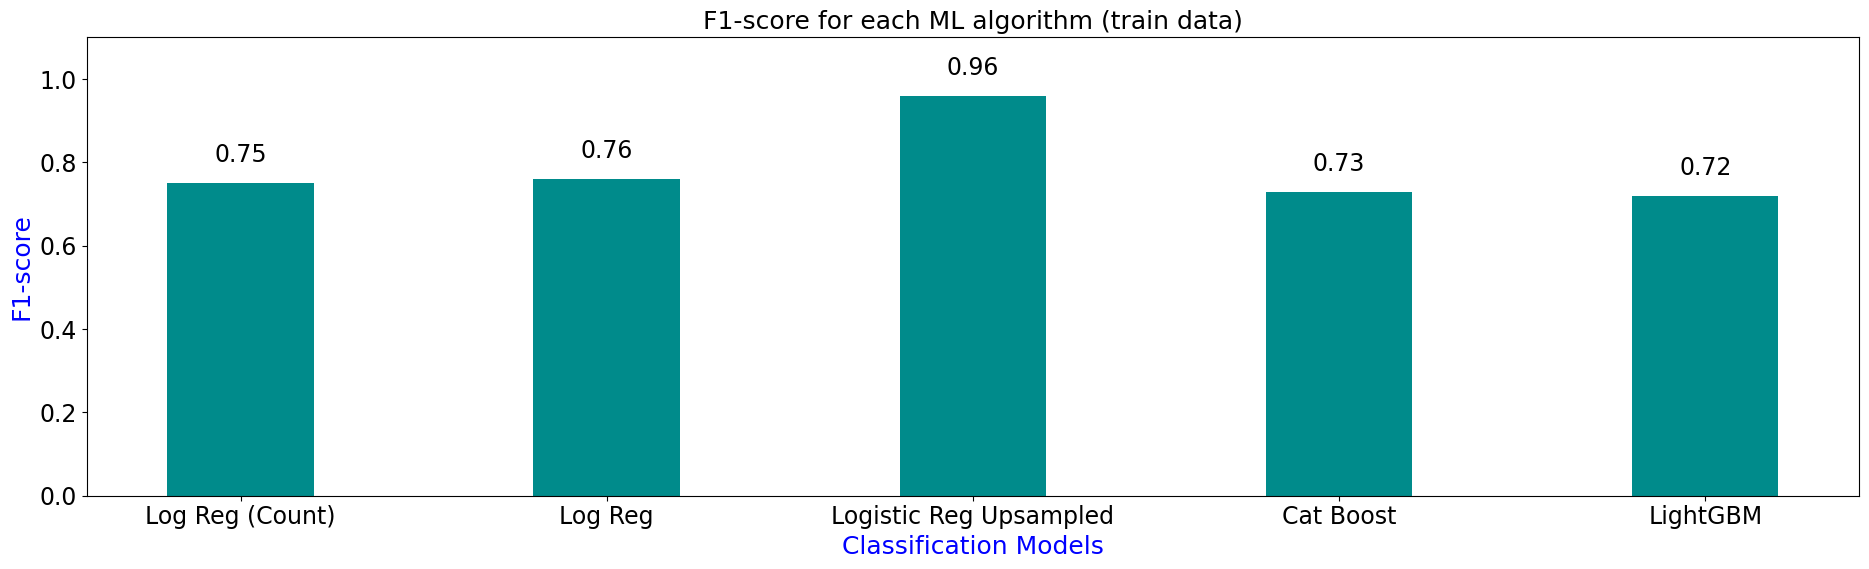

In [68]:
# Generate F1-score plots

plt.rcParams.update({'font.size': 17, 
                     'text.color' : 'black', 
                     'axes.labelcolor' : "blue"})
# plt.rcParams.update({'axes.titlesize': 'large'})
fig, ax = plt.subplots(figsize=(19, 6))

x = ['Log Reg (Count)',
     'Log Reg', 
     'Logistic Reg Upsampled', 
     'Cat Boost',
    'LightGBM']

y = [best_score_vect, 
     best_score_tfidf, 
     best_score_tfidf_up,
     best_score_catboost,
     best_score_LGBM]

ax.bar(x, y, width=0.4, color='#008B8B')
ax.set_title('F1-score for each ML algorithm (train data)', fontsize=18)
ax.set_xlabel('Classification Models', fontsize=18)
ax.set_ylabel('F1-score', fontsize=18)
ax.set_ylim(0, 1.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout();

###  Вывод: Максимальное значение F1-меры приходится на модель логистической регрессии (F1-score = 0.76), построенные для модели TD-IDF на выборке с учетом дисбалансов таргетов (upsampled). ***Протестируем оба алгоритма на тестовой выборке.***

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Здорово, что рассмотрела разные модели и сделала перебор гиперпараметров! 
    
Видно, что проделана большая работа 👍 
    
Сейчас нужно внести некоторые исправления, нро в целом работа практически готова.
    
</div>

## Выводы

In [61]:
# Logistic Regression TF-IDF (upsampled)
f1_logreg_tfidf_test_up = round(f1_score(grid_up.predict(tf_idf_X_test), y_test), 2)
print("F1-score Logistic Regression TF-IDF (test data): {:.2f}".format(f1_logreg_tfidf_test_up))

F1-score Logistic Regression TF-IDF (test data): 0.78


<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v3:</b> 
    
Необходимый порог по метрике F1 > 0.75 преодолен, поздравляю!
    
</div>

In [62]:
y_pred_logreg_up = grid_up.predict(tf_idf_X_test)
confusion_matrix(y_pred_logreg_up, y_test)

array([[27685,   647],
       [  882,  2645]])

In [73]:
print('\n',classification_report(y_test, y_pred_logreg_up))


               precision    recall  f1-score   support

           0       0.98      0.97      0.97     28567
           1       0.75      0.80      0.78      3292

    accuracy                           0.95     31859
   macro avg       0.86      0.89      0.87     31859
weighted avg       0.95      0.95      0.95     31859



### ***Вывод:*** Наилучшая модель классификации текста комментариев твиттера - это логистическая регрессия с максимальным значением F1-меры 0.78, построенная на модели "мешка слов". Модель построена после корректировки дисбалансов таргетов методом upsampling. Главгая диагональ сonfusion matrix демонстрирует, что модель обучается хорошо: количство ложно пложительных и ложно отрицательных предсказаний менее 20%.

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v3:</b> Общая рекомендация по улучшению работу: поправить расчет матриц ошибок, поменять местами переменные в функции confusion_matrix()
    
</div>

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера v2:</b> Сейчас на тестировании нужно оставить только одну модель: если на кросс-валидации победила модель с upsampling, то ее одну нужно протестировать.
    
Как ты правильно заметила, модель с upsampling переобучается, а на тесте результат сильно хуже. Поэтому рекомендуется вместо upsampling указать параметр class_weight = 'balanced'
    
Как рекомендация: текст в выводе можно написать нежирным шрифтом =)
    
</div>

<font color=blue>
<b> ✔️ 👍Заключение ревьювера:</b> Юлия, у тебя хорошая работа, в целом ты получила нужный результат!
   
Здорово что попробовала разные векторизации, сделала перебор гиперпараметров.
    
Сейчас по проекту есть небольшие замечания — нужно убрать преобразование в юникод, поправить лемматизацию текста, а также убрать расчет на тестовой выборке для всех моделей. Тестирование нужно сделать только для одной лучшей модели, которую выбрали по кросс-валидации. 
    
В остальном все хорошо, я отметил рекомендации =)
    
Отправляю работу для ознакомления с ходом проверки, а также если есть вопросы — смело задавай их, я постараюсь тебе помочь 😊

Жду твоего ответа!
 </font>

<div class="alert alert-info"> <b>ℹ️ Yulia:</b> 

Арсен, большое спасибо за ревью и крутые ссылки, очень интересно!

- попробовала сгруппировать по PEP-8, не знаю, насколько удалось
- файл с помощью исключения прочитала
- кодировку убрала
- лемматизацию английского текста другим классом сделала WordNetLemmatizer()
- scoring='f1' в решетчатом поиске прописала
- pipeline попробовала обернуть - ноут умирает, не вытягивает модели
- дисбаланс убрала с помощью upsampling, но на результаты F1-меры он особо не повлиял.
    
Спасибо за обратную связь :)

   
</div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Работа стала значительно лучше! 
    
По замечаниям, нужно поправить только момент с тестовой выборкой. Мы не можем ее использовать для всех моделей, а также для расчета матрицы ошибок на каждой модели, когда делаем кросс-валидацию.
    
Я добавил также некоторые рекомендации.
    
</div>

<div class="alert alert-info"> <b>ℹ️ Yulia v2:</b> 
    
- предсказания на тесте убрала из раздела обучения
- добавила ignore warnings
- добавила в модели class_weight='balanced'
- гистограммы переделала в бар-плоты, оси подписала
- еще раз посмотрела на pipeline
    pipe_lr = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=5,
                                          class_weight='balanced'))])
    
     Получается, что отдельно не надо масштабировать выборки countvetorizer(), tfidfvectorizer()? можно все зашить в конвейер - и сразу в модель? Тогда и обучаться можно на изначально выделенных выборках X_train, y_train?
    
Спасибо за рекомендации, аугментация - крутая штука. А ты с текстами работаешь? Где тебя можно в соцсетях добавить, чтобы не потерять в будущем? :)
</div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v3:</b> Работа принята, поздравляю! 
    
По твоим вопросам:
    
- в pipeline действительно можно загрузить несколько вариантов векторизатора и выбрать наилучший с помощью GridSearchCV. Я посмотрел, что ты пока не запускала Pipeline в проекте, нам нужно поправить тип кавычек, если чть )) Но думаю ты и так это заметали :)
    
- я увлекаюсь задачами анализа текстов, но пока больше как хобби. Сейчас работа у меня в области применения ML для нефтегазовой отрасли.
    
В интернете моих проектов по ML в публичном доступе пока нет, т.к. в прошлом я инженер) В основном можно найти мои старые инженерные статьи и проекты, если ввести имя и фамилию =) Около 3-х лет назад я начал заниматься ML и сменил работу, но в планах дополнить профиль на github хорошими проектами.
    
Вообще ты можешь в любое время написать мне через куратора, в слаке (скоро перейдем в пачку), до конца обучения 
    
Если тебе интересна тема анализа текстов, советую присоединиться к вебинару буквально сегодня, либо потом посмотреть его в записи:    
- First step in NLP Bootcamp набери в гугл эту фразу и пройди по первой ссылке) Завтра стартует соревнование по текстам на Kaggle, советую поучаствовать, тем более если еще не делала проектов в Kaggle. Там будут как новички так и опытные участники.
    
Могу посоветовать такие группы в телеграмм, где можно узнать новости в области DS о соревнованиях, вакансиях, собеседованиях:
    
https://t.me/machinelearning_interview
    
https://t.me/eda_shad
    
</div>

### Вывод: Наилучшая модель классификации текста - это логистическая регрессия с максимальным значением F1-меры.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны

***Thank you for going through this project. Your comments are more then welcome to ybezginova2021@gmail.com***

***Best wishes,***

***Yulia***